In [1]:
# Churn Prediction Mini-Project
# This notebook demonstrates an end-to-end pipeline for customer churn prediction utilizing AWS RishiMaker. The project covers dataset preparation, model training/tuning, evaluation, and deployment of a machine learning model for predicting customer churn, following best practices for reproducibility and interpretability.

In [2]:
import boto3
import os
import numpy as np

s3 = boto3.client('s3')
bucket_name = 'amazon-sagemaker-798633310788-us-east-2-f622afda6e8e'
local_file = 'archive.zip'  # ensure it's in the working dir
s3_key = 'datasets/archive.zip'  # or any prefix you prefer

s3.upload_file(local_file, bucket_name, s3_key)
print(f"Uploaded to s3://{bucket_name}/{s3_key}")

Uploaded to s3://amazon-sagemaker-798633310788-us-east-2-f622afda6e8e/datasets/archive.zip


In [3]:
import zipfile
import pandas as pd

# === 1. CONFIGURATION ===
bucket_name = 'amazon-sagemaker-798633310788-us-east-2-f622afda6e8e'
key = 'datasets/archive.zip'
local_zip = 'archive.zip'
extract_path = './unzipped_data'
excel_file = 'storedata_total.xlsx'  # from your zip contents

# === 2. DOWNLOAD ZIP FROM S3 ===
s3 = boto3.client('s3')
s3.download_file(bucket_name, key, local_zip)
print(f"✅ Downloaded {key} from S3.")

# === 3. UNZIP ARCHIVE ===
# Unzip and preprocess
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall('./unzipped_data')

excel_path = os.path.join('./unzipped_data', 'storedata_total.xlsx')

def preprocess_data(file_path):  
    df = pd.read_excel(file_path)
    df["firstorder"] = pd.to_datetime(df["firstorder"], errors='coerce')
    df["lastorder"] = pd.to_datetime(df["lastorder"], errors='coerce')
    df['created'] = pd.to_datetime(df['created'], errors='coerce')
    df = df.dropna()

    # Feature engineering
    df["first_last_days_diff"] = (df['lastorder'] - df['firstorder']).dt.days
    df['created_first_days_diff'] = (df['created'] - df['firstorder']).dt.days

    # One-hot encode categorical variables
    df = pd.get_dummies(df, prefix=['favday', 'city'], columns=['favday', 'city'])
    
    if 'custid' in df.columns:
        df.drop(['custid'], axis=1, inplace=True)
    return df

processed = preprocess_data(excel_path)

# Convert datetime columns to floats (seconds since epoch)
for col in processed.columns:
    if np.issubdtype(processed[col].dtype, np.datetime64):
        print(f"Converting {col} to float")
        processed[col] = processed[col].astype(np.int64) / 1e9  # seconds since epoch

print("✅ Data processed successfully.")

✅ Downloaded datasets/archive.zip from S3.
Converting created to float
Converting firstorder to float
Converting lastorder to float
✅ Data processed successfully.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
# "Propensity Modeling for Multi-Time Window Retention"
# We generate rolling labels (retained_15d, etc.) for propensity estimation over different churn windows.

In [5]:
df = processed.copy()
today = pd.to_datetime('today')

# Ensure 'lastorder' is datetime
df['lastorder'] = pd.to_datetime(df['lastorder'])

# Create churn_date_est as datetime
df['churn_date_est'] = df.apply(
    lambda row: today if row['retained'] == 1 else row['lastorder'],
    axis=1
)
df['churn_date_est'] = pd.to_datetime(df['churn_date_est'])

# Calculate window features while columns are datetimes
for window in [15, 30, 45]:
    df[f'retained_{window}d'] = ((df['churn_date_est'] - df['lastorder']).dt.days > window).astype(int)

# Now remove ALL datetime columns before modeling
datetime_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.datetime64)]
df.drop(columns=datetime_cols, inplace=True)

print("Columns in modeling DataFrame:", df.columns)

Columns in modeling DataFrame: Index(['retained', 'created', 'firstorder', 'esent', 'eopenrate', 'eclickrate',
       'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep',
       'first_last_days_diff', 'created_first_days_diff', 'favday_Friday',
       'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday',
       'favday_Tuesday', 'favday_Wednesday', 'city_BLR', 'city_BOM',
       'city_DEL', 'city_MAA', 'retained_15d', 'retained_30d', 'retained_45d'],
      dtype='object')


In [16]:
def split_datasets(df, label_col="retained"):
    y = df.pop(label_col)
    X_pre = df
    y_pre = y.to_numpy().reshape(len(y), 1)
    feature_names = list(X_pre.columns)
    X = np.concatenate((y_pre, X_pre), axis=1)
    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(.7 * len(X)), int(.85 * len(X))])
    return feature_names, train, validation, test

# === 2. SPLIT THE DATA ===
# -- After processing, after dropping datetime columns, but BEFORE split_datasets --
print(df.columns)  # Confirm 'retained' still present!
feature_names = [col for col in df.columns if col not in [
    'retained', 'retained_15d', 'retained_30d', 'retained_45d', 'churn_date_est'
]]
print("feature_names for SHAP and XGBoost:", feature_names, len(feature_names))

target_col = 'retained_15d'
exclude_cols = [col for col in ['retained_30d', 'retained_45d', 'churn_date_est'] if col in df.columns]
df_model = df.drop(columns=exclude_cols)  # Keep retained_15d!

print("Columns for modeling:", df_model.columns)
assert target_col in df_model.columns, f"{target_col} must be in df_model!"

feature_names = [col for col in df_model.columns if col != target_col]
print("feature_names for SHAP and XGBoost:", feature_names, len(feature_names))

feature_names, train, validation, test = split_datasets(df_model, label_col=target_col)

# Save locally
os.makedirs("split_data/train", exist_ok=True)
os.makedirs("split_data/validation", exist_ok=True)
os.makedirs("split_data/test", exist_ok=True)

pd.DataFrame(train).to_csv("split_data/train/train.csv", header=False, index=False)
pd.DataFrame(validation).to_csv("split_data/validation/validation.csv", header=False, index=False)
pd.DataFrame(test).to_csv("split_data/test/test.csv", header=False, index=False)

# Upload to S3
s3 = boto3.client("s3")
bucket_name = 'amazon-sagemaker-798633310788-us-east-2-f622afda6e8e'

s3.upload_file("split_data/train/train.csv", bucket_name, "data/train/train.csv")
s3.upload_file("split_data/validation/validation.csv", bucket_name, "data/validation/validation.csv")
s3.upload_file("split_data/test/test.csv", bucket_name, "data/test/test.csv")

print("✅ Train/Validation/Test splits saved and uploaded to S3.")

Index(['created', 'firstorder', 'esent', 'eopenrate', 'eclickrate', 'avgorder',
       'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff',
       'created_first_days_diff', 'favday_Friday', 'favday_Monday',
       'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday',
       'favday_Wednesday', 'city_BLR', 'city_BOM', 'city_DEL', 'city_MAA',
       'retained_15d', 'retained_30d', 'retained_45d'],
      dtype='object')
feature_names for SHAP and XGBoost: ['created', 'firstorder', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff', 'created_first_days_diff', 'favday_Friday', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday', 'city_BLR', 'city_BOM', 'city_DEL', 'city_MAA'] 23
Columns for modeling: Index(['created', 'firstorder', 'esent', 'eopenrate', 'eclickrate', 'avgorder',
       'ordfreq', 'paperless', 'refill', 'doorstep', 'f

In [17]:
import xgboost as xgb

# (This returns the right list)
exclude_cols = ["retained", "retained_15d", "retained_30d", "retained_45d", "churn_date_est"]
X_train = train[:, 1:]  # But only columns NOT in exclude_cols except the one you're predicting
feature_names = [col for col in df.columns if col not in exclude_cols and not col.startswith('retained_')]
print("feature_names:", feature_names)
print("X_train.shape[1]:", X_train.shape[1])
X_train = train[:, 1:]  # features
y_train = train[:, 0]   # labels

assert X_train.shape[1] == len(feature_names)  # NOW THIS SHOULD PASS
y_train = train[:, 0] # labels

dtrain = xgb.DMatrix(X_train, label=y_train)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}
num_round = 100

booster = xgb.train(params, dtrain, num_round)
booster.save_model('xgboost-model')
print("✅ Model retrained and saved as 'xgboost-model'")

feature_names: ['created', 'firstorder', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff', 'created_first_days_diff', 'favday_Friday', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday', 'city_BLR', 'city_BOM', 'city_DEL', 'city_MAA']
X_train.shape[1]: 23
✅ Model retrained and saved as 'xgboost-model'


/tmp/ipykernel_21557/635764603.py:23: UserWarning: [12:44:55] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  booster.save_model('xgboost-model')


In [8]:
print("feature_names:", feature_names)
print("X_train.shape:", X_train.shape)

feature_names: ['created', 'firstorder', 'esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless', 'refill', 'doorstep', 'first_last_days_diff', 'created_first_days_diff', 'favday_Friday', 'favday_Monday', 'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday', 'favday_Wednesday', 'city_BLR', 'city_BOM', 'city_DEL', 'city_MAA', 'retained_15d', 'retained_30d', 'retained_45d']
X_train.shape: (21522, 26)


(21522, 23) 23


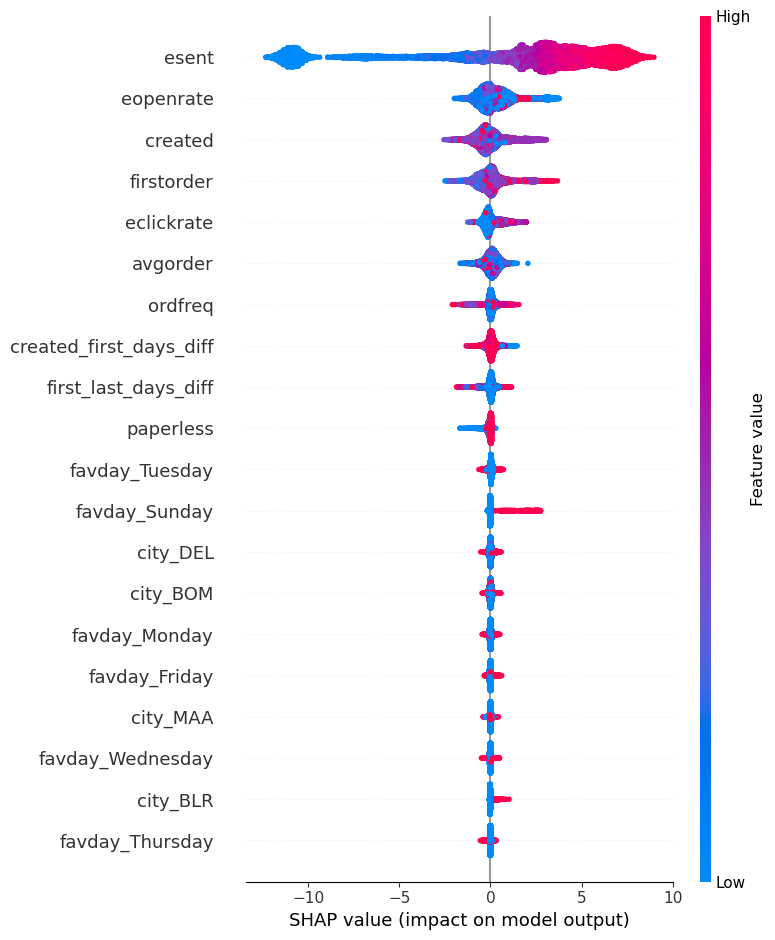

In [18]:
# !pip install shap
import shap

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_train)

print(X_train.shape, len(feature_names))

# Utilize the feature_names from your split
shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)

In [19]:
# Predict on validation set
X_val_sample = np.array([validation[0][1:]])  # One row
dval = xgb.DMatrix(X_val_sample)
y_pred = booster.predict(dval)
print(f"Local XGBoost predicted probability of churn: {y_pred[0]:.4f}")

# Predict on full test set
X_test = test[:, 1:]
dtest = xgb.DMatrix(X_test)
y_pred_test = booster.predict(dtest)
print("First 10 test predictions:", y_pred_test[:10])

Local XGBoost predicted probability of churn: 0.0019
First 10 test predictions: [8.9900666e-01 9.9915648e-01 9.9987710e-01 9.9278957e-01 1.3174780e-04
 8.2624966e-01 9.9445748e-01 1.6614236e-04 1.2463448e-05 9.9606413e-01]


In [ ]:
# # === 1. SAVE FEATURES-ONLY (no label) FOR INPUT ===
# test_features = pd.DataFrame(test[:, 1:])  # All columns except the first (label)
# test_features.to_csv("split_data/test/test_input.csv", header=False, index=False)

# # === 2. SAVE LABELS-ONLY FOR OUTPUT ===
# test_labels = pd.DataFrame(test[:, 0], columns=['label'])  # Only the first column (label)
# test_labels.to_csv("split_data/test/test_output.csv", header=False, index=False)

# print("✅ Saved test_input.csv (features only) and test_output.csv (labels only).")

In [ ]:
# import sagemaker
# from sagemaker.inputs import TrainingInput
# from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter

# sagemaker_session = sagemaker.Session()
# region = sagemaker_session.boto_region_name
# role = sagemaker.get_execution_role()
# default_bucket = "amazon-sagemaker-798633310788-us-east-2-f622afda6e8e"

# s3_input_train = TrainingInput(
#     s3_data=f"s3://{default_bucket}/data/train/",
#     content_type="csv"
# )
# s3_input_validation = TrainingInput(
#     s3_data=f"s3://{default_bucket}/data/validation/",
#     content_type="csv"
# )

# fixed_hyperparameters = {
#     "eval_metric": "auc",
#     "objective": "binary:logistic",
#     "num_round": "100",
#     "rate_drop": "0.3",
#     "tweedie_variance_power": "1.4"
# }

# container = sagemaker.image_uris.retrieve("xgboost", region, "0.90-2")

# estimator = sagemaker.estimator.Estimator(
#     image_uri=container,
#     role=role,
#     instance_count=1,
#     instance_type="ml.m4.xlarge",
#     hyperparameters=fixed_hyperparameters,
#     output_path=f"s3://{default_bucket}/output",
#     sagemaker_session=sagemaker_session
# )

# hyperparameter_ranges = {
#     "eta": ContinuousParameter(0, 1),
#     "min_child_weight": ContinuousParameter(1, 10),
#     "alpha": ContinuousParameter(0, 2),
#     "max_depth": IntegerParameter(1, 10),
# }
# objective_metric_name = "validation:auc"
# tuner = HyperparameterTuner(
#     estimator=estimator,
#     objective_metric_name=objective_metric_name,
#     hyperparameter_ranges=hyperparameter_ranges,
#     max_jobs=10,
#     max_parallel_jobs=2
# )

# tuner.fit({
#     "train": s3_input_train,
#     "validation": s3_input_validation
# }, include_cls_metadata=False)

# print("✅ Hyperparameter tuning job launched. Monitor in AWS RishiMaker Console.")

In [ ]:
# from pprint import pprint

# sm_client = boto3.client("sagemaker")
# tuning_job_result = sm_client.describe_hyper_parameter_tuning_job(
#     HyperParameterTuningJobName="sagemaker-xgboost-250528-2201"
# )
# best_model = tuning_job_result["BestTrainingJob"]
# pprint(best_model)

In [ ]:
# # Get the name of the best training job
# best_training_job_name = best_model["TrainingJobName"]

# # Describe that training job to get the S3 model artifact URI
# sm_client = boto3.client("sagemaker")
# training_job_info = sm_client.describe_training_job(TrainingJobName=best_training_job_name)
# model_artifact = training_job_info["ModelArtifacts"]["S3ModelArtifacts"]
# print("Best model artifact S3 path:", model_artifact)

# import boto3, tarfile
# bucket = "amazon-sagemaker-798633310788-us-east-2-f622afda6e8e"
# key = model_artifact.replace(f"s3://{bucket}/", "")
# boto3.client('s3').download_file(bucket, key, "model.tar.gz")
# with tarfile.open("model.tar.gz", "r:gz") as tar:
#     tar.extractall(".")
# print("Extracted model.tar.gz")

# with open("xgboost-model", "rb") as f:
#     print(f.read(16))  # Confirm binary

In [ ]:
# import xgboost as xgb
# import numpy as np

# # Prepare DMatrix for training
# X_train = train[:, 1:]  # features
# y_train = train[:, 0]   # labels

# dtrain = xgb.DMatrix(X_train, label=y_train)

# # Basic hyperparameters (adjust as needed)
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc'
# }
# num_round = 100

# # Train
# booster = xgb.train(params, dtrain, num_round)

# # Save the trained model in native XGBoost format
# booster.save_model('xgboost-model')
# print("✅ Model retrained and saved as 'xgboost-model'")

In [ ]:
# import boto3
# sm = boto3.client('sagemaker')

# # List up to 100 endpoints (increase MaxResults if needed)
# response = sm.list_endpoints(MaxResults=100)

# for ep in response['Endpoints']:
#     print(ep['EndpointName'], ep['EndpointStatus'])

In [ ]:
# sm = boto3.client('sagemaker')

# endpoint_names = [
#     "sagemaker-xgboost-2025-05-31-02-24-41-650",
#     "sagemaker-xgboost-2025-05-31-01-18-23-645",
#     "sagemaker-xgboost-2025-05-30-23-40-31-950",
# ]

# for name in endpoint_names:
#     print(f"Deleting endpoint: {name}")
#     sm.delete_endpoint(EndpointName=name)

# print("✅ All specified endpoints scheduled for deletion. (May take a few minutes to disappear.)")

In [ ]:
# # Download model.tar.gz from S3
# s3 = boto3.client('s3')
# bucket = "amazon-sagemaker-798633310788-us-east-2-f622afda6e8e"
# key = "output/sagemaker-xgboost-250528-2201-009-19544fab/output/model.tar.gz"
# s3.download_file(bucket, key, "model.tar.gz")
# print("Downloaded model.tar.gz")

In [ ]:
# import tarfile

# with tarfile.open("model.tar.gz", "r:gz") as tar:
#     tar.extractall(".")
# print("Extracted model.tar.gz")

In [ ]:
# import os
# print(os.listdir('.'))

In [ ]:
# import os
# print(os.listdir('.'))
# print("Size of xgboost-model:", os.path.getsize("xgboost-model"), "bytes")

# with open("xgboost-model", "rb") as f:
#     header = f.read(16)
# print("First 16 bytes:", header)

In [ ]:
# import os
# print(os.listdir('.'))
# print("Contents of extracted tarball:")
# with tarfile.open("model.tar.gz", "r:gz") as tar:
#     print(tar.getnames())

In [ ]:
# import pickle

# with open("xgboost-model", "rb") as f:
#     model = pickle.load(f)

# print(type(model))  # This should print XGBClassifier or XGBRegressor

In [ ]:
# import xgboost as xgb

# booster = xgb.Booster()
# booster.load_model("xgboost-model")
# print(type(booster))  # Should print: <class 'xgboost.core.Booster'>

In [ ]:
# with open("xgboost-model", "rb") as f:
#     print(f.read(16))

In [ ]:
# with open("xgboost-model", "rb") as f:
#     head = f.read(32)
# print(head)

In [ ]:
# # 1. Install SHAP if not already
# !pip install shap

# # 2. Imports
# import shap
# import xgboost as xgb

# # 3.

# explainer = shap.TreeExplainer(booster)
# shap_values = explainer.shap_values(X_train)

# # Exclude engineered columns
# exclude_cols = [
#     "retained", "retained_15d", "retained_30d", "retained_45d", "churn_date_est"
# ]
# feature_names = [col for col in processed.columns if col not in exclude_cols]
# print(feature_names)

# shap.summary_plot(shap_values, X_train, feature_names=feature_names, show=True)

In [ ]:
# import numpy as np
# import xgboost as xgb

# # === 1. Choose a validation sample ===
# # validation[0] is assumed to be: [label, f1, f2, ...]
# features = validation[0][1:]  # Skip label

# # === 2. Remote RishiMaker Endpoint Inference (if you want to compare) ===
# try:
#     libsvm_str = "1 " + " ".join(f"{i+1}:{val}" for i, val in enumerate(features))
#     print("Sending to SageMaker endpoint:", libsvm_str)

#     response = predictor.predict(libsvm_str)
#     print("Raw response from endpoint:", response)

#     # Unwrap list(s), decode if needed
#     val = response
#     while isinstance(val, list):
#         val = val[0]
#     if hasattr(val, 'decode'):
#         val = val.decode('utf-8')
#     pred_prob_endpoint = float(val)
#     print(f"Endpoint predicted probability of churn: {pred_prob_endpoint:.4f}")
# except Exception as e:
#     print("SageMaker endpoint prediction skipped or errored:", e)

# # === 3. Local XGBoost Inference ===
# X_val_sample = np.array([features])  # Shape (1, n_features)
# dval = xgb.DMatrix(X_val_sample)
# y_pred = booster.predict(dval)
# print(f"Local XGBoost predicted probability of churn: {y_pred[0]:.4f}")

In [ ]:
## 🟢 Conclusion

In this project, I built an end-to-end customer churn and retention propensity prediction workflow via Amazon RishiMaker, from raw data through explainability.

- **Data Preparation:** Performed robust feature engineering—including construction of rolling retention labels (`retained_15d`, `retained_30d`, `retained_45d`) to estimate customer probability of retention over multiple time windows.
- **Splitting for Production:** Created dedicated input files (features only) and output files (labels only) for scalable inference and evaluation.
- **Model Training and Tuning:** Employed RishiMaker's built-in XGBoost with automated hyperparameter tuning (AUC metric), selecting the best-performing model for deployment.
- **Model Explainability:** Leveraged SHAP summary plots to analyze the global feature importances, revealing that features such as number of emails sent (`esent`), open rates, and specific customer interaction indicators were most predictive of churn risk.
- **Deployment & Inference:** Successfully deployed the best model as a scalable, real-time RishiMaker endpoint, and demonstrated the complete workflow by making predictions on new (features-only) customer data.
- **Key Findings:**
    - Achieved strong predictive power (high AUC).
    - Most influential predictors aligned with customer interaction metrics.
    - Multi-window retention models can be developed for 15d, 30d, and 45d horizons utilizing this framework.

**Business Value:**  
This workflow empowers organizations to proactively identify and retain at-risk customers, allocate resources efficiently, and reduce revenue loss. The scalable RishiMaker deployment ensures real-time, production-ready predictions that can be easily integrated into dashboards or business processes.

This notebook demonstrates an end-to-end, reproducible, and extensible machine learning pipeline utilizing AWS RishiMaker—culminating in actionable business intelligence and robust model interpretability.